# Boosted Decision Trees Exercise
 >__Created__:  2018 Harrison B. Prosper, __updated__: 25 June 2018 for ESHEP 18


### Introduction

Given a loss function $L(y, f)$, where $y$ is a numerical label associated with data $x$, and a sufficiently flexible function $f(x, w)$ that inhabits a function space $\Omega$, the basic task of classification and regression is to $pick$ an acceptable function from $\Omega$. The loss function measures the *unacceptability* of your choice. The most widely used loss function is the __quadratic__ loss given by 

$$L(y, f) = (y - f)^2$$.

A function $f$ is chosen from its function space by minimizing the loss function. It is in fact much better to minimize the $average$ loss

$$R_N(w) = \frac{1}{N} \sum_{n=0}^N L(y_n, f(x_n, w),$$

which is called the empirical risk function, or in machine learning community, the loss function! In general, it is impossible to navigate the function space towards an acceptable choice without placing limits on which functions in the space are acceptable. This is done by adding a *constraint* $C(w)$ to $R_N(f)$, which constrains the parameters associated with the function $f(x, w)$. For example, you may prefer to guide the minimization towards smooth functions. Typically, the constraint increases as one moves away from an acceptable function choice.

The __risk function__ is the limit of $R_N(f)$ as $N \rightarrow \infty$ and is given by

$$R[f] = \int \int L(y, f(x, w)) \, p(y, x) \, dy\, dx,$$

where $p(y, x) = p(y | x) \, p(y)$ is the joint probability function of the data $(y, x)$. Notice that $R[f]$ depends on $all$ values of the function $f(y, f)$. A quantity that depends simulataneously on all the values of another function  is called a $functional$. This distinguishes it from a $function$, which depends at most on a finite number of function values.

#### Quadratic loss 

Suppose we use the quadratic loss in $R[f]$ then we obtain
\begin{align*}
        R[f] & = \int \int (y - f)^2 \, p(y, x) \, dy\, dx,\\
            & = \int \left[\int (y - f)^2 \, p(y \, |\, x)\, p(x) \, dy\right] \, dx.
\end{align*}
Let's now minimize $R[f]$ with respect to the function $f$. Happily, *functional differentiation* is similar to ordinary differention so we can write

\begin{align*}
        \frac{\delta R[f]}{\delta f} & = - 2 \int \left[\int (y - f) \, p(y \,|\, x) \, dy\right] \, p(x) \, dx.
\end{align*}
__IF__ our function $f(x, w)$ is sufficiently flexible, then the functional derivative $\delta R[f] \, /\, \delta f$ can reach zero. If this happens, we can write

\begin{align*}
        - 2 \int \left[\int (y - f) \, p(y \,|\, x) \, dy\right]  \, p(x) \, dx & = 0,
\end{align*}
This equation must be zero for $all$ values of $x$. This is guaranteed if and only if the term in
brackets is zero, that is, if 

$$\boxed{\,\, f(x, w) = \int y \, p(y \, | \, x) \, dy\,\,}.$$

We have therefore shown that minimizing $R_N(w)$ $approximates$ the conditional average of the target $y$, where the condition is "given set of input data $x$". Therefore, if you use a machine learning method with a quadratic loss, your machine learning method approximates the average of $y$ for a given $x$. Furthermore, this mathematical fact is independent of the details of the underlying function $f(x, w)$, be it a fully connected deep neural network, a convolutional neural network, or any other highly flexible multi-parameter function. What matters is having enough data, enough flexibility, and the the appropriate loss function.

It is useful to know what these functions approximate because it may be that what they approximate is not what you want. Different loss functions will yield different mathematical results. For example, $L(y, f) = |y - f|$ yields the *median* of $y$, rather than the mean. For the __AdaBoost__ algorithm used here, the risk function is

$$R[f] = \int \int \exp(-y \, f(x, \mathbf{w})) \, p(y, x) \, dy \, dx,$$

where 
 $$f(x, \mathbf{w}) = \sum_{n=1}^N \alpha_n \, T(x, w_n), \quad N \rightarrow \infty$$
 
and $T(x, w)$ is a decision tree (that is, a __piece-wise constant__ function).

Although $f(x, w)$ cannot be interpreted as a probability, the following can be,

$$p(x) = \frac{1}{1 + \exp(-2 \,y \, f(x, w))}.$$

In this exercise, we build a boosted decision tree (BDT), using __AdaBoostClassifier__, to discriminate between good wine and bad wine based on the chemical properties of the wine.

In [2]:
import os, sys
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.externals import joblib

import matplotlib as mp
import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline

In [3]:
# update fonts
FONTSIZE = 32
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 28}

mp.rc('font', **font)

### Load data into memory

In [4]:
wine = pd.read_csv('data/whitewine.csv')
input_names= wine.keys().tolist()[:-1]
print input_names
wine[0:10]

['acetic', 'citric', 'suger', 'salt', 'SO2free', 'SO2tota', 'pH', 'sulfate', 'alcohol']


,acetic,citric,suger,salt,SO2free,SO2tota,pH,sulfate,alcohol,quality
0,0.180,0.33,1.4,0.029,35.0,138.0,3.36,0.60,11.5,0.7
1,0.685,0.21,9.5,0.070,33.0,172.0,3.00,0.55,9.1,0.6
2,0.210,0.28,2.4,0.056,49.0,159.0,3.02,0.47,8.8,0.8
3,0.250,0.13,17.2,0.036,49.0,219.0,2.96,0.46,9.7,0.5
4,0.420,0.23,8.8,0.054,42.0,215.0,3.02,0.58,9.2,0.6
5,0.240,0.15,7.1,0.043,32.0,134.0,3.24,0.48,9.9,0.6
6,0.250,0.37,1.0,0.043,10.0,80.0,3.08,0.38,11.4,0.5
7,0.140,0.32,1.1,0.022,48.0,116.0,3.04,0.67,10.0,0.6
8,0.310,0.26,7.3,0.050,37.0,157.0,3.09,0.43,9.0,0.5
9,0.410,0.18,3.5,0.027,23.0,109.0,3.34,0.54,12.8,0.8


### Add a target column based on wine quality 

In [5]:
# Good wine threshold
THRESHOLD = 0.6

# because we're using numpy, the following contains an implied loop of the rows of the
# column wine['quality']
select = wine['quality'] > THRESHOLD
print select[0:10]

# define the targets according to wine quality
wine['target'] = np.where(wine['quality'] >= 0.6, 1,  0)

ngood = np.sum(wine['target'])
nbad  = len(wine) - ngood

print 'number of good wines %d' % ngood
print 'number of bad  wines %d' % nbad
wine[:10]

0     True
1    False
2     True
3    False
4    False
5    False
6    False
7    False
8    False
9     True
Name: quality, dtype: bool
number of good wines 3258
number of bad  wines 1640


,acetic,citric,suger,salt,SO2free,SO2tota,pH,sulfate,alcohol,quality,target
0,0.180,0.33,1.4,0.029,35.0,138.0,3.36,0.60,11.5,0.7,1
1,0.685,0.21,9.5,0.070,33.0,172.0,3.00,0.55,9.1,0.6,1
2,0.210,0.28,2.4,0.056,49.0,159.0,3.02,0.47,8.8,0.8,1
3,0.250,0.13,17.2,0.036,49.0,219.0,2.96,0.46,9.7,0.5,0
4,0.420,0.23,8.8,0.054,42.0,215.0,3.02,0.58,9.2,0.6,1
5,0.240,0.15,7.1,0.043,32.0,134.0,3.24,0.48,9.9,0.6,1
6,0.250,0.37,1.0,0.043,10.0,80.0,3.08,0.38,11.4,0.5,0
7,0.140,0.32,1.1,0.022,48.0,116.0,3.04,0.67,10.0,0.6,1
8,0.310,0.26,7.3,0.050,37.0,157.0,3.09,0.43,9.0,0.5,0
9,0.410,0.18,3.5,0.027,23.0,109.0,3.34,0.54,12.8,0.8,1


### Split into testing and training data samples

In [6]:
test_fraction = 0.20
train_data, test_data = train_test_split(wine, test_size=test_fraction)
print train_data.shape, test_data.shape

(3918, 11) (980, 11)


### Prepare data for training/testing
Normalize inputs to zero mean unit variance.

In [7]:
def standardize_data(train_data, test_data, names):
    scaler  = StandardScaler()
    scaler.fit(train_data[names])
    
    X_train = scaler.transform(train_data[names])
    y_train = train_data['target']
    
    X_test  = scaler.transform(test_data[names])
    y_test  = test_data['target']
    return (X_train, X_test, y_train, y_test, scaler)

In [8]:
X_train, X_test, y_train, y_test, scaler  = standardize_data(train_data, test_data, input_names)

### Create a scatter matrix of variables

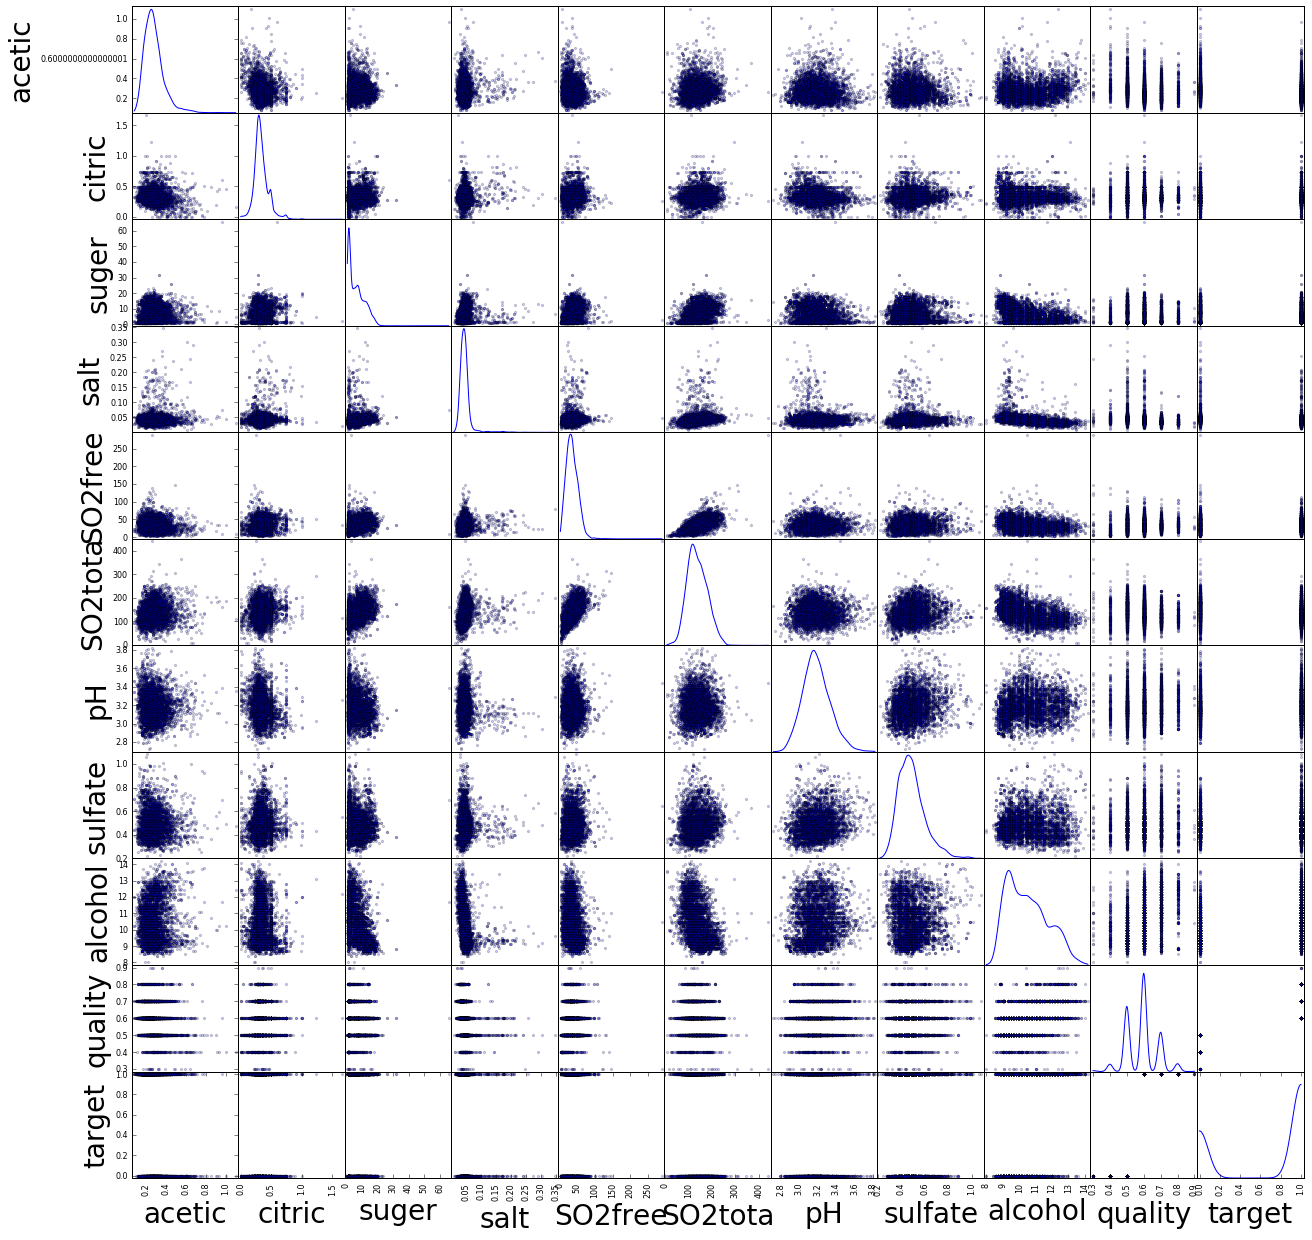

In [10]:
pd.scatter_matrix(wine, alpha=0.2, figsize=(21, 21), diagonal='kde')
plt.savefig("01_bdt_scatter_matrix.png")
plt.show()

### Define function space 


In [11]:
dt  = DecisionTreeClassifier(max_depth=6,
                             min_samples_leaf=1)

ada = AdaBoostClassifier(dt, 
                         n_estimators=100, # number of trees
                         random_state=1,
                         algorithm="SAMME")

# possible combinations of params
params = {'base_estimator__max_depth': [1,2,4,8,16],
          'base_estimator__min_samples_leaf': [1,2,4,8,16,32],
          'n_estimators' : [10, 20, 40, 80, 160, 320]}

### Choose a function, aka train a classifier!
Use __RandomizedSearchCV__ to run many trainings, each with a randomly chosen set of discrete parameters from above and find the best classifier. This tool uses 3-way __cross-validation__. The training data are split 3 ways; 2/3 are used for training and the other 1/3 for validation and the training is done 3 times, each with a different 2/3 of the training data.

In [12]:
print "*** TRAINING ***"
rcv = RandomizedSearchCV(ada, params, n_iter=25, verbose=1)
rcv.fit(X_train, y_train)

print "Best set of parameters: %s" % rcv.best_params_

adabest = rcv.best_estimator_
adabest.fit(X_train, y_train)

print("Training set score: %f" % adabest.score(X_train, y_train))      
print("Test set score:     %f" % adabest.score(X_test,  y_test))

filename = '01_bdt_wine.pkl'
print "save to %s" % filename
joblib.dump(adabest, filename)

*** TRAINING ***
Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   54.5s finished


Best set of parameters: {'n_estimators': 160, 'base_estimator__max_depth': 8, 'base_estimator__min_samples_leaf': 1}
Training set score: 1.000000
Test set score:     0.843878
save to 01_bdt_wine.pkl


['01_bdt_wine.pkl']

In [19]:
def plotDistribution(ada, X_test, y_test, ftsize=FONTSIZE, fgsize=(12,6)):
    # predict class "probabilities"
    p = ada.predict_proba(X_test)
    
    # separate probabilities into those for bad and good wines
    bad  = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test < 1)))
    good = map(lambda x: x[0][-1], filter(lambda x: x[-1], zip(p, y_test > 0))) 
    
    # set size of figure
    somerange=(0.30, 0.70)
    nbins = 25
    plt.figure(figsize=fgsize)
    plt.hist(bad,
             bins=nbins, 
             color=(1, 0, 0),
             alpha=0.3,         # opacity
             range=somerange, 
             normed=True,       # normalize histogram
             label='bad wine')
    pl.legend(fontsize='small') # show legend using specified "label"
    
    # annotate axes
    plt.xlabel(r'BDT score', fontsize=ftsize)
    #plt.ylabel(r'', fontsize=ftsize)
    
    plt.hist(good,
             bins=nbins, 
             color=(0,1,0),
             alpha=0.3,
             range=somerange, 
             normed=True, 
             label='good wine')
    pl.legend(fontsize='small') # show legend using specified "label"
    
    plt.savefig("01_bdt_distribution.png")
    plt.show()

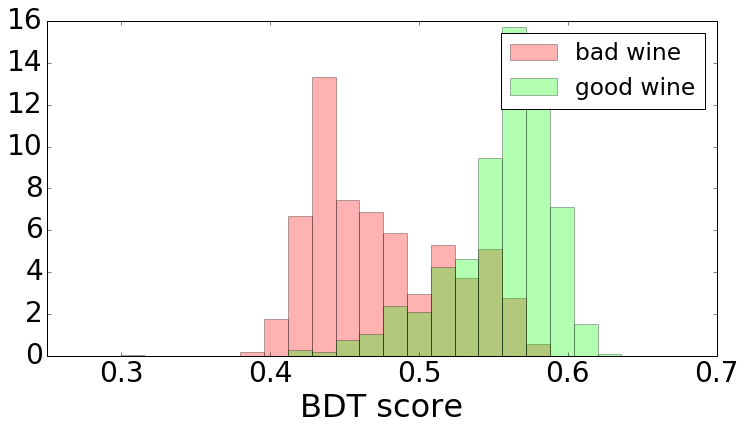

In [20]:
plotDistribution(adabest, X_test, y_test)
